<a href="https://colab.research.google.com/github/DavideRutigliano/Bengali-CV/blob/master/Bengali_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
input_dir = "../input/bengaliai/"

In [0]:
%%capture

!pip uninstall -y kaggle
!pip install kaggle
!apt-get install fuse-zip

import os

os.environ["KAGGLE_USERNAME"] = "lazcoder"
os.environ["KAGGLE_KEY"] = "f8513d63f03470f5f848e303e747159c"

raw_data_dir = "input/raw"
!rm -r {raw_data_dir}
!kaggle competitions download -c bengaliai-cv19 -p {raw_data_dir}

!mkdir ../input
!mkdir {input_dir}

!fuse-zip {raw_data_dir}/bengaliai-cv19.zip {input_dir}

In [3]:
!ls {input_dir}

class_map.csv		   test_image_data_3.parquet
sample_submission.csv	   train.csv
test.csv		   train_image_data_0.parquet
test_image_data_0.parquet  train_image_data_1.parquet
test_image_data_1.parquet  train_image_data_2.parquet
test_image_data_2.parquet  train_image_data_3.parquet


In [0]:
from tqdm.auto import tqdm
from glob import glob
import gc
import cv2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [5]:
train_csv = pd.read_csv(input_dir + 'train.csv')
train_csv.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [6]:
data = []

for path in tqdm(sorted(glob(input_dir + 'train_image_data_*.parquet'))):
    data.append(pd.read_parquet(path))

train_data = pd.concat(data)
del data
gc.collect()
train_data.head()

NameError: ignored

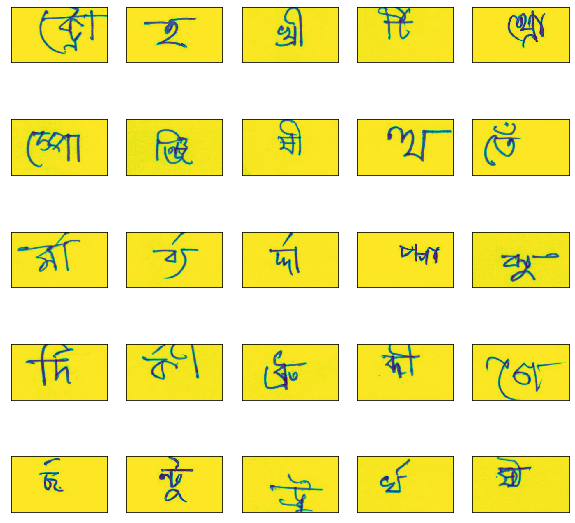

In [11]:
fig = plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    idx = np.random.randint(0, train_data.shape[0])
    plt.imshow(train_data.iloc[i].values[1:].astype(np.uint8).reshape(137,236))

plt.show()

In [0]:
def crop_resize(img, size=128):
    _, thresh = cv2.threshold(img,
                              30, 255,
                              cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(thresh,
                                   cv2.RETR_LIST,
                                   cv2.CHAIN_APPROX_SIMPLE)[-2:]
    
    idx = 0 
    ls_xmin = []
    ls_ymin = []
    ls_xmax = []
    ls_ymax = []
    
    for cnt in contours:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        ls_xmin.append(x)
        ls_ymin.append(y)
        ls_xmax.append(x + w)
        ls_ymax.append(y + h)

    xmin = min(ls_xmin)
    ymin = min(ls_ymin)
    xmax = max(ls_xmax)
    ymax = max(ls_ymax)

    roi = img[ymin:ymax, xmin:xmax]

    roi[roi < 28] = 0
    lx = xmax - xmin
    ly = ymax - ymin
    l = max(lx, ly) + 16

    roi = np.pad(roi,
                 [((l - ly)//2,), ((l - lx)//2,)],
                 mode='maximum')

    return cv2.resize(roi, (size, size))
    
def preprocess_input(img, size=128):
    img = crop_resize(img, size=size)
    return img

In [0]:
img_dir = "./preprocessed/"
!mkdir {img_dir}

In [28]:
input_shape = (1, 128, 128)

for img_idx in tqdm(train_csv.image_id.values):
    img = train_data[train_data.image_id == img_idx]\
                    .values[0][1:]\
                    .astype(np.uint8).reshape(137, 236)
                          
    img = preprocess_input(img, size=input_shape[1])
    cv2.imwrite(img_dir + img_idx + ".png", img)

In [45]:
out_dir = 'output'
!rm -r {out_dir}
!mkdir {out_dir}

!cp -r {img_dir} {out_dir}
!cp {input_dir}/train.csv {out_dir}

cmd = """
cat <<EOF > ./output/dataset-metadata.json
{
  "title": "bengali-preprocessed",
  "id": "lazcoder/bengali-preprocessed",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}
EOF
"""

!eval {cmd}
!cat {out_dir}/dataset-metadata.json
!kaggle datasets create -u --dir-mode zip -p {out_dir}

rm: cannot remove 'output': No such file or directory
{
  "title": "bengali-preprocessed",
  "id": "lazcoder/bengali-preprocessed",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}
Starting upload for file preprocessed.zip
100% 1.13G/1.13G [00:30<00:00, 39.6MB/s]
Upload successful: preprocessed.zip (1GB)
Starting upload for file train.csv
100% 5.99M/5.99M [00:08<00:00, 742kB/s]
Upload successful: train.csv (6MB)
Your public Dataset is being created. Please check progress at https://www.kaggle.com/lazcoder/bengali-preprocessed
